In [1]:
import torch
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import datetime
import logging
import json
import os
from resnet18_no_pre_diy import resnet18_no_pre_diy
from train_model import train_model
from count_macs_parm import compute_params_flops

In [2]:
batch_size = 16
pic_size = 224
root = "malevis_train_val_224x224"
num_class = 26
num_epochs = 25

train_transforms = transforms.Compose([transforms.Resize((pic_size, pic_size)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       ])
val_transforms = transforms.Compose([transforms.Resize((pic_size, pic_size)),
                                     transforms.ToTensor()
                                     ])
train_dataset = datasets.ImageFolder(root = os.path.join(root,"train"),transform = train_transforms)
test_dataset = datasets.ImageFolder(root = os.path.join(root,"val"),transform = val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset)
data_loaders = {'train': train_loader, 'val': test_loader}
dt = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")

In [3]:

# 定义日志器，处理器，格式器
logger = logging.getLogger(name="train") #创建日志器
logger.setLevel(logging.INFO) #设置日志的打印级别 DEBUG为最低级别

fh = logging.FileHandler(filename=f'resnet18_no_pre_diy_{pic_size}_{batch_size}_{num_epochs}_logfile_{dt}.log',mode='a',encoding="utf-8") #创建日志处理器，用文件存放日志
sh = logging.StreamHandler()#创建日志处理器，在控制台打印 

#创建格式器，指定日志的打印格式
# fmt = logging.Formatter("[%(asctime)s]-[%(levelname)s]-[%(filename)s]-[Line:%(lineno)d]-[Msg:%(message)s]")
fmt = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
#给处理器设置格式
fh.setFormatter(fmt=fmt)
sh.setFormatter(fmt=fmt)
#给日志器添加处理器
logger.addHandler(fh)
logger.addHandler(sh)
#调用日志器
logger.info("尝试调用日志器")

2023-06-02 18:35:48,922 - train - INFO - 尝试调用日志器


In [4]:
model = resnet18_no_pre_diy()
compute_params_flops(logger,cnn=model, n_channels=3, n_size=pic_size)

2023-06-02 18:35:49,071 - train - INFO - macs, params = 1.824G, 11.190M


In [5]:
# 加载网络模型，定义好损失函数和优化器
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device",device)
print("==============================")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1) # Decay LR by a factor of 0.1 every 1 epochs

logger.info(model)

device cuda:0


2023-06-02 18:35:49,871 - train - INFO - ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [6]:
print("开始训练！")
st = time.time()
model, loss_dic,acc_dic,time_dic =train_model(model=model, criterion=criterion, optimizer=optimizer, scheduler=exp_lr_scheduler,
            data_loaders=data_loaders,pic_size=pic_size, device=device,logger=logger,dt=dt,
            batch_size=16,num_epochs=num_epochs)
print(dt)
print("loss_dic".center(30,"="))
print(loss_dic)
print("acc_dic".center(30,"="))
print(acc_dic)
print("time_dic".center(30,"="))
print(time_dic)
et = time.time()
print(f"共计用时{et-st}秒 合计{(et-st)/60}分")

2023-06-02 18:35:49,895 - train - INFO - epoch 1/25开始训练！
2023-06-02 18:35:49,895 - train - INFO - =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


开始训练！


2023-06-02 18:36:14,394 - train - INFO - train epoch_loss: 1.1012  epoch_acc: 70.29% cost_time:24.49861216545105
2023-06-02 18:36:31,915 - train - INFO - val epoch_loss: 0.9197  epoch_acc: 77.86% cost_time:17.519893407821655
2023-06-02 18:36:31,920 - train - INFO - 目前验证集精度最好的是第1轮，精度是: 77.86%
2023-06-02 18:36:31,920 - train - INFO - epoch 2/25开始训练！
2023-06-02 18:36:31,921 - train - INFO - =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
2023-06-02 18:36:55,213 - train - INFO - train epoch_loss: 0.3996  epoch_acc: 88.73% cost_time:23.29119873046875
2023-06-02 18:37:12,484 - train - INFO - val epoch_loss: 1.2121  epoch_acc: 79.11% cost_time:17.27010679244995
2023-06-02 18:37:12,489 - train - INFO - 目前验证集精度最好的是第2轮，精度是: 79.11%
2023-06-02 18:37:12,490 - train - INFO - epoch 3/25开始训练！
2023-06-02 18:37:12,490 - train - INFO - =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
2023-06-02 18:37:35,820 - train - INFO - train epoch_loss: 0.2478  epoch_acc: 92.87% cost_time:23

2023-06-02_183548
===========loss_dic===========
{'train': [1.101168967465778, 0.399630257619115, 0.2478448237806231, 0.1635499685914716, 0.11728251622426887, 0.08412697780345167, 0.06830256436386013, 0.04344878203400595, 0.04267859547901745, 0.03140956437738438, 0.02774496472010819, 0.03063706833073501, 0.01948080461205861, 0.012071023963962344, 0.01468543687442274, 0.012707056031564946, 0.004995493296478494, 0.010860526607909808, 0.011691378691586459, 0.01434296694067358, 0.012079846426089176, 0.020306122037278267, 0.00698077771338221, 0.008753088480886647, 0.012551706496936047], 'val': [0.9196938556327335, 1.2120695045206114, 0.6882285468121844, 0.6027544450955382, 0.8890607744415168, 0.7967869703428438, 0.7869802748061367, 0.9111830011962337, 0.760581822279645, 0.8365386187161845, 0.8387370132412615, 0.7647054912723543, 0.8631238731620019, 0.9595615071139943, 0.9454662386977001, 0.8977849264870715, 0.8857836275583627, 1.055719285279252, 0.8601310054820225, 0.9760455259483247, 0.967

In [7]:
loss_dic_f_name = f'resnet18_no_pre_diy_{pic_size}_{batch_size}_{num_epochs}epoch_loss_dic_{dt}.json'
acc_dic_f_name = f'resnet18_no_pre_diy_{pic_size}_{batch_size}_{num_epochs}epoch_acc_dic_{dt}.json'
time_dic_f_name = f'resnet18_no_pre_diy_{pic_size}_{batch_size}_{num_epochs}epoch_time_dic_{dt}.json'

with open(loss_dic_f_name,"w") as f:
    json.dump(loss_dic,f)
with open(acc_dic_f_name,"w") as f:
    json.dump(acc_dic,f)
with open(time_dic_f_name,"w") as f:
    json.dump(time_dic,f)

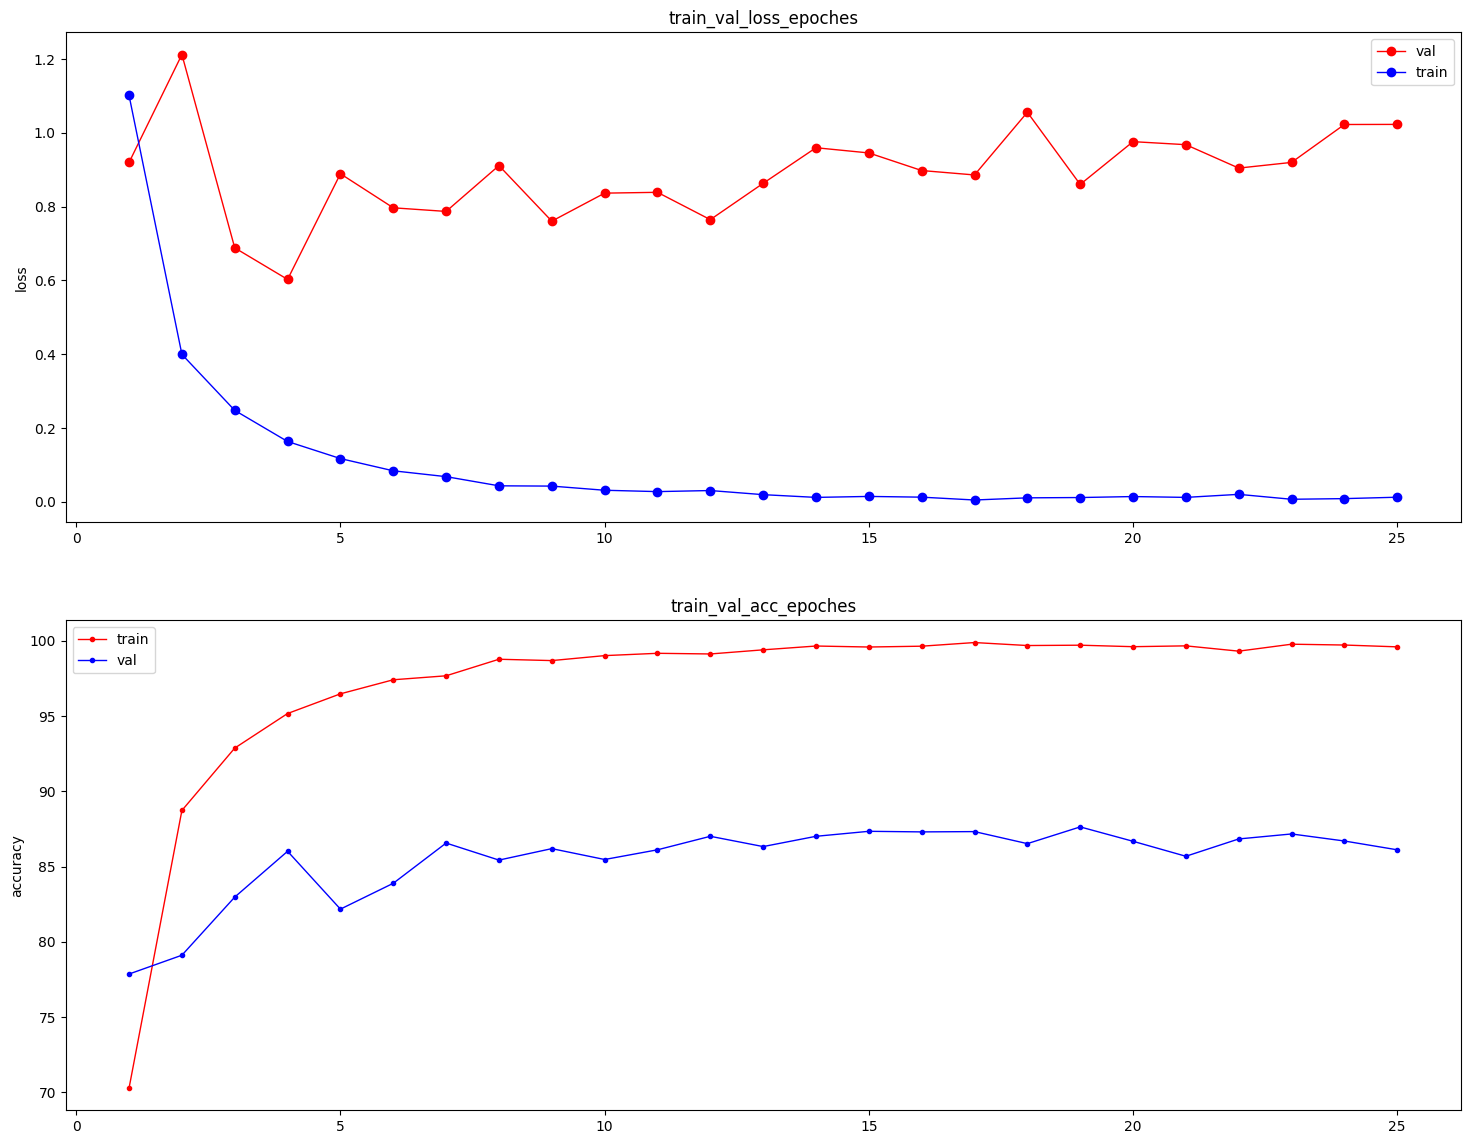

In [8]:

x = range(1, num_epochs+1)
y1 = loss_dic["val"]
y2 = loss_dic["train"]
plt.figure(figsize=(18,14))
plt.subplot(211)
plt.plot(x, y1, color="r", linestyle="-", marker="o", linewidth=1, label="val")
plt.plot(x, y2, color="b", linestyle="-", marker="o", linewidth=1, label="train")
# for i in range(len(x)):
#      plt.text(x[i], y1[i] + 0.1, '%s' %round(y1[i],3), ha='center', fontsize=10)
#      plt.text(x[i], y2[i] - 0.1, '%s' %round(y2[i],3), ha='center', fontsize=10, va='bottom')
plt.legend()
plt.title('train_val_loss_epoches')
plt.ylabel('loss')

plt.subplot(212)
y3 = acc_dic["train"]
y4 = acc_dic["val"]
plt.plot(x, y3, color="r", linestyle="-", marker=".", linewidth=1, label="train")
plt.plot(x, y4, color="b", linestyle="-", marker=".", linewidth=1, label="val")
# for i in range(len(x)):
#      plt.text(x[i], y5[i] + 0.5, '%s' %y5[i], ha='center', fontsize=10)
#      plt.text(x[i], y6[i] - 2, '%s' %y6[i], ha='center', fontsize=10, va='bottom')
plt.legend()
plt.title('train_val_acc_epoches')
plt.ylabel('accuracy')
pic_fname = f'resnet18_no_pre_diy_{pic_size}_{batch_size}_{num_epochs}_train_val_loss_acc_epoches_{dt}.jpg'
plt.savefig(pic_fname)
plt.show()


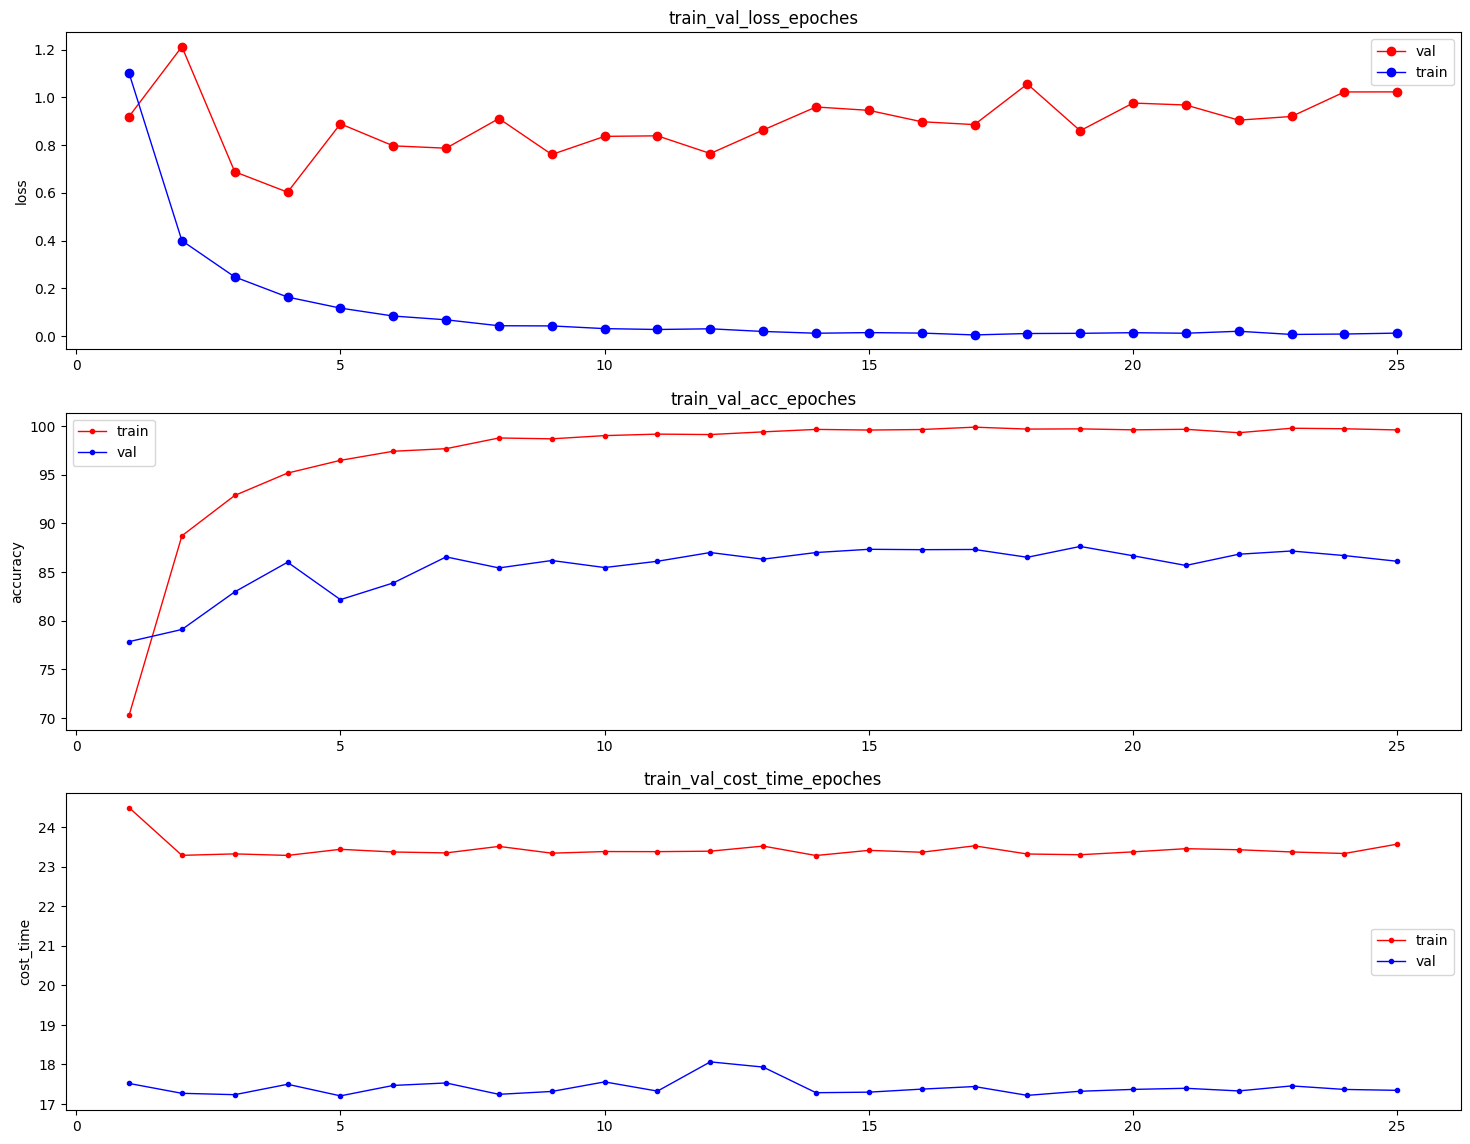

In [9]:

x = range(1, num_epochs+1)
y1 = loss_dic["val"]
y2 = loss_dic["train"]

plt.figure(figsize=(18,14))
plt.subplot(311)
plt.plot(x, y1, color="r", linestyle="-", marker="o", linewidth=1, label="val")
plt.plot(x, y2, color="b", linestyle="-", marker="o", linewidth=1, label="train")
# for i in range(len(x)):
#      plt.text(x[i], y1[i] + 0.1, '%s' %round(y1[i],3), ha='center', fontsize=10)
#      plt.text(x[i], y2[i] - 0.1, '%s' %round(y2[i],3), ha='center', fontsize=10, va='bottom')
plt.legend()
plt.title('train_val_loss_epoches')
plt.ylabel('loss')

plt.subplot(312)
y3 = acc_dic["train"]
y4 = acc_dic["val"]
plt.plot(x, y3, color="r", linestyle="-", marker=".", linewidth=1, label="train")
plt.plot(x, y4, color="b", linestyle="-", marker=".", linewidth=1, label="val")
# for i in range(len(x)):
#      plt.text(x[i], y5[i] + 0.5, '%s' %y5[i], ha='center', fontsize=10)
#      plt.text(x[i], y6[i] - 2, '%s' %y6[i], ha='center', fontsize=10, va='bottom')
plt.legend()
plt.title('train_val_acc_epoches')
plt.ylabel('accuracy')

plt.subplot(313)
y5 = time_dic["train"]
y6 = time_dic["val"]
plt.plot(x, y5, color="r", linestyle="-", marker=".", linewidth=1, label="train")
plt.plot(x, y6, color="b", linestyle="-", marker=".", linewidth=1, label="val")
plt.legend()
plt.title('train_val_cost_time_epoches')
plt.ylabel('cost_time')


pic_fname = f'resnet18_no_pre_diy_{pic_size}_{batch_size}_{num_epochs}_train_val_loss_acc_cost_time_epoches_{dt}.jpg'
plt.savefig(pic_fname)
plt.show()
